In [111]:
# Importing Libraries

import numpy as np
from matplotlib import pyplot 
from scipy.special import erf  

In [123]:
# Given Variables
Ma  = 0.2
Re  = 50

# Input Parameters

# x-direction variables 

Nx                  = 200               # Number of Nodes
x_start             = 0.0               # Physical start location
x_end               = 2*np.pi           # Physical end location

# y-direction variables

Ny                  = 200               # Number of Nodes
y_start             = 0.0               # Physical start location
y_end               = 2*np.pi           # Physical end location

# Other variables
             
order_of_derivative = 2                 # Derivative order
dim                 = 2                 # Two-Dimensional Space

# Fluid properties

R_u                 = 8.31446261815324  # Universal Gas Constant J/(mol * K)
m_air               = 28.97 / 1000        # Molar Mass of Air
gamma               = 7.0 / 5.0         # Standard Conditions of Air
R_s                 = R_u / m_air       # Specific gas contant for air
C_v                 = R_s / (gamma - 1.0)    
C_p                 = R_s + C_v           
Pr                  = 0.71


# Time varaibles

cfl                 = 0.1               # CFL number
t_end               = 1                 # End time
iter_end            = 100000            # Stop condition (may remove)

# Initial Conditions


p_0                 = 100000
T_0                 = 300
c_0                 = np.sqrt(gamma*R_s*T_0)
v_0                 = Ma * c_0
L                   = 2* np.pi
rho_0               = p_0 / (R_s * T_0)
mu                  = (rho_0 * v_0 * L) / Re
Sc                  =  1                 # Schmidt number
D                   = rho_0 / mu / Sc       # Diffusion coefficient
kappa               = mu * C_p / Pr
delta               = 0.8     
species             = 2    
print(D)   
print(mu) 

0.1146021196197918
10.134455154196049


In [113]:
# Parameters that can be calculated by input parameters

# Statment for Number of ghost cell required per boundary

if(order_of_derivative == 2):
    ngc = 1                     

elif(order_of_derivative == 4):
    ngc = 2  
    
elif(order_of_derivative == 6):
    ngc = 3

# x-direction parameters

dx      = (x_end - x_start) / (Nx)                                                   # Mesh Resolution
x       = np.linspace(x_start + dx/2 - ngc*dx, x_end - dx/2 + ngc*dx, Nx + 2*ngc)    # Generate array from 0 to 2pi with 100 nodes

# y-direction parameters

dy      = (y_end - y_start) / (Ny)                                                    # Mesh resolution
y       = np.linspace(y_start + dy/2 - ngc*dy, y_end - dy/2 + ngc*dy, Ny + 2*ngc)     # Generate array from 0 to 2pi with 100 nodes


V         = np.zeros((Nx+2*ngc, Ny+2*ngc, dim+3))                                       # density + 2 dimension of velocity + energy
Q         = np.zeros((Nx+2*ngc, Ny+2*ngc, dim+3))                                       # density + 2 dimension of momentum + energy
T         = np.zeros((Nx+2*ngc, Ny+2*ngc))                                              # May need to change
P         = np.zeros((Nx+2*ngc, Ny+2*ngc))
Y_2       = np.zeros((Nx+2*ngc, Ny+2*ngc,species))
J         = np.zeros((Nx+2*ngc, Ny+2*ngc,species))

rho_tot   = np.zeros((Nx+2*ngc, Ny+2*ngc))
# Mesh Generation

X,Y = np.meshgrid(x,y)


In [114]:
# Fill Ghost Cell function

def fill_gc_2D(V,ngc):
    V [:ngc,ngc:-ngc]     = V[-2*ngc:-ngc, ngc:-ngc]   # Fill the left ghost cell with the right data cell
    V [-ngc:,ngc:-ngc]    = V[ngc   :2*ngc,ngc:-ngc]   # Fill the right ghost cell with the left data cell
    V [ngc:-ngc,:ngc]     = V[ngc:-ngc, -2*ngc:-ngc]   # Fill the left ghost cell with the top data cell
    V [ngc:-ngc,-ngc:]    = V[ngc:-ngc, ngc  :2*ngc]   # Fill the right ghost cell with the bottom data cell
    
    # Fill corners
    V [-ngc:,-ngc:]     = V[ngc:2*ngc,ngc:2*ngc]        # Fill the right-top ghost cell
    V [:ngc,-ngc:]      = V[-2*ngc:-ngc,ngc:2*ngc]      # Fill the left-top ghost cell
    V [-ngc:,:ngc]      = V[ngc:2*ngc,-2*ngc:-ngc]      # Fill the right-bottom ghost cell
    V [:ngc,:ngc]       = V[-2*ngc:-ngc,-2*ngc:-ngc]    # Fill the left-bottom ghost cell

    return(V)

In [115]:
# Intial condtions set up
def initial_condition_TGV(Y_2,delta,V,v_0,p_0,rho_0,T_0,C_v,Nx,Ny,x,y,ngc):
    for i in range(Nx):
        for j in range(Ny):
            # width               = 2*np.pi
            # bump_x              = 0.5 * (erf((x[i] - width / 4) / delta) - erf((x[i] - 3 * width / 4) / delta))
            # bump_y              = 0.5 * (erf((y[j] - width / 4) / delta) - erf((y[j] - 3 * width / 4) / delta))
            #Y_2[i, j, 0]          = bump_x * bump_y
            Y_2[i, j, 0]          = (1+np.sin(x[i]))/2
            Y_2[i, j, 1]          = 1.0 - Y_2[i, j, 0]
            V[ngc+i, ngc+j, 0]  =  rho_0*Y_2[i, j, 0]
            V[ngc+i, ngc+j, 1]  =  rho_0*Y_2[i, j, 1]
            V[ngc+i, ngc+j, 2]  =  v_0*np.sin(x[ngc+i])*np.cos(y[ngc+j])
            V[ngc+i, ngc+j, 3]  = -v_0*np.cos(x[ngc+i])*np.sin(y[ngc+j])
            V[ngc+i, ngc+j, 4]  =  rho_0*(C_v*T_0 + 0.5*(V[ngc+i, ngc+j, 2]*V[ngc+i, ngc+j, 2] + V[ngc+i, ngc+j, 3]*V[ngc+i, ngc+j, 3]))
            P[ngc+i, ngc+j]     =  p_0 + (np.cos(2*x[ngc+i]) + np.cos(2*y[ngc+j]))*(rho_0/16.0)
            T[ngc+i, ngc+j]     =  T_0
            #rho_tot             =  V[ngc+i, ngc+j, 0] + V[ngc+i, ngc+j, 1] 
    return V, P, T, rho_tot,Y_2


In [116]:
# Variables from Ideal Gas Law
def pressure_from_ideal_gas_law(V,R_s,T,ngc):
    P[:,:]                                   = (V[:,:,0] + V[:,:,1])*R_s*T[:,:]
    return(P)


In [117]:
# Variables from internal Engergy

def calculate_T_from_e(e, C_v):
    T                    = e / C_v
    return(T)

In [118]:
# Time Step function

def time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T):
    u_mag     = np.sqrt(V[ngc:-ngc,ngc:-ngc,2]*V[ngc:-ngc,ngc:-ngc,2] + V[ngc:-ngc,ngc:-ngc,3]*V[ngc:-ngc,ngc:-ngc,3])
    c_0       = np.sqrt(gamma*R_s*T[ngc:-ngc,ngc:-ngc])
    u_mag    += c_0
    dt_adv    = min(cfl * dx / (np.max(np.amax(u_mag)) ), cfl * dy / np.max(np.amax(u_mag)))
    nu        = mu/(V[ngc:-ngc,ngc:-ngc,0] + V[ngc:-ngc,ngc:-ngc,1])
    dt_diff   = min(cfl * (dx*dx) / (np.max(np.amax(nu)) ), cfl * (dy*dy) / np.max(np.amax(nu)))
    dt        = min(dt_adv,dt_diff)
    return(dt)

In [119]:
# Derivatives

# Initialize df_dx_2D

df_dx_2D      = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
df_dy_2D      = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
d2f_dx2_2D    = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
d2f_dy2_2D    = np.zeros((Nx + 2*ngc, Ny + 2*ngc))

def df_dx_second_order_centered_2D(V,dx,ngc):
    
    df_dx_2D[ngc:-ngc,ngc:-ngc]   = (V[ngc+1:,ngc:-ngc] - V[ngc-1:-ngc-1,ngc:-ngc]) / (2*dx)                                            
    
    return(df_dx_2D)

# Initialize df_dy_2D



def df_dy_second_order_centered_2D(V,dy,ngc):
    
    df_dy_2D[ngc:-ngc,ngc:-ngc]   = (V[ngc:-ngc,ngc+1:] - V[ngc:-ngc,ngc-1:-ngc-1]) / (2*dy)  
    
    return(df_dy_2D)


# Second Derivative Second Order Functions

# Initialize d2f_dx2_2D



def non_conservative_d2f_dx2_second_order_centered_2D(V,dx,ngc):                                                     
    d2f_dx2_2D[ngc:-ngc,ngc:-ngc]            = (V[ngc+1:,ngc:-ngc] - 2*V[ngc:-ngc,ngc:-ngc] + V[ngc-1:-ngc-1,ngc:-ngc]) / (dx**2)                                           
    return(d2f_dx2_2D)


# Initialize d2f_dy2_2D


def non_conservative_d2f_dy2_second_order_centered_2D(V,dy,ngc):                                                     
    d2f_dy2_2D[ngc:-ngc,ngc:-ngc]            = (V[ngc:-ngc,ngc+1:] - 2*V[ngc:-ngc,ngc:-ngc] + V[ngc:-ngc,ngc-1:-ngc-1]) / (dy**2)                                            
    return(d2f_dy2_2D)

In [120]:
# Calculating Tau's
def calculate_tau(u,v,dx,dy,mu):
    tau_xx = (2.0/3.0)*mu*(2*df_dx_second_order_centered_2D(u,dx,ngc) - df_dy_second_order_centered_2D(v,dy,ngc))
    tau_yy = (2.0/3.0)*mu*(2*df_dy_second_order_centered_2D(v,dy,ngc) - df_dx_second_order_centered_2D(u,dx,ngc))
    tau_xy = mu*(df_dy_second_order_centered_2D(u,dy,ngc) + df_dx_second_order_centered_2D(v,dx,ngc))
    tau_xx = fill_gc_2D(tau_xx,ngc)
    tau_yy = fill_gc_2D(tau_yy,ngc)
    tau_xy = fill_gc_2D(tau_xy,ngc)
    return(tau_xx,tau_yy,tau_xy)

def get_Q_from_V(V,Q):
    Q[:,:,0] = V[:,:,0]                         #rho*Y[0]   
    Q[:,:,1] = V[:,:,1]                         #rho*Y[1]
    Q[:,:,2] = (V[:,:,0]+V[:,:,1])*V[:,:,2]     #rho*u
    Q[:,:,3] = (V[:,:,0]+V[:,:,1])*V[:,:,3]     #rho*v
    Q[:,:,4] = V[:,:,4] * (V[:,:,0] + V[:,:,1])   #Energy
    return(Q)

def get_V_from_Q(Q,V):
    V[:,:,0] = Q[:,:,0]                         #rho*Y[0] 
    V[:,:,1] = Q[:,:,1]                         #rho*Y[1]                    
    V[:,:,2] = Q[:,:,2]/(Q[:,:,0]+Q[:,:,1])     # u
    V[:,:,3] = Q[:,:,3]/(Q[:,:,0]+Q[:,:,1])     # v
    V[:,:,4] = Q[:,:,4]                         # Energy        
    return(V)

In [121]:
# Getting diffusive flux for continuity temporarily
def get_J(J, V, D):
    J[:,:,0] = D * (non_conservative_d2f_dx2_second_order_centered_2D(V[:,:,0], dx, ngc) + non_conservative_d2f_dy2_second_order_centered_2D(V[:,:,0], dy, ngc))
    J[:,:,1] = D * (non_conservative_d2f_dx2_second_order_centered_2D(V[:,:,1], dx, ngc) + non_conservative_d2f_dy2_second_order_centered_2D(V[:,:,1], dy, ngc))  
    
    J[:,:,0] = fill_gc_2D(J[:,:,0],ngc)
    J[:,:,1] = fill_gc_2D(J[:,:,1],ngc)
    
    return J


    

0.9999383162408303
0.9999383162408303
0.0


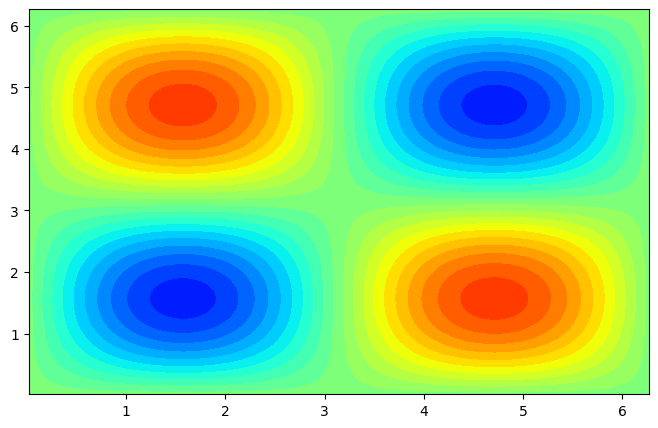

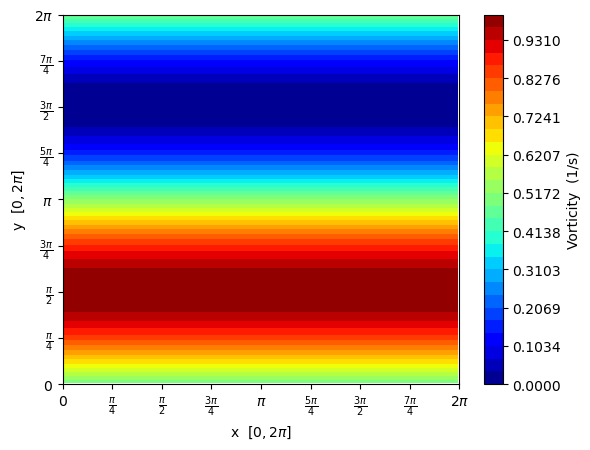

0.9999383162408303
0.9999383162408303
0.9999378842322758
0.9999378842322758
0.9999375119364257
0.9999375119454089
0.9999371709582162
0.9999371709300057
0.9999372234928955
0.9999372234928955
0.9999381999974576
0.9999381999974576
0.9999396268414531
0.9999396268414531
0.9999415037917928
0.9999415037917928
0.9999438306051857
0.9999438306051857
0.9999466070281361
0.9999466070281361
0.9999498327969452
0.9999498327969452
0.9999535076377084
0.9999535076377084
0.9999576312663158
0.9999576312663158
0.9999622033884509
0.9999622033884509
0.9999672236995911
0.9999672236995911
0.9999726918850066
0.9999726918850066
0.9999786076197601
0.9999786076197601
0.9999849705687073
0.9999849705687072
0.999991780386496
0.999991780386496
0.9999990367175675
0.9999990367175675
1.000006739196155
1.000006739196155
1.0000148874462846
1.0000148874462846
1.000023481081776
1.000023481081776
1.0000325197062427
1.0000325197062427
1.0000420029130916
1.0000420029130916
1.0000519302855249
1.0000519302855249
1.000062301396539


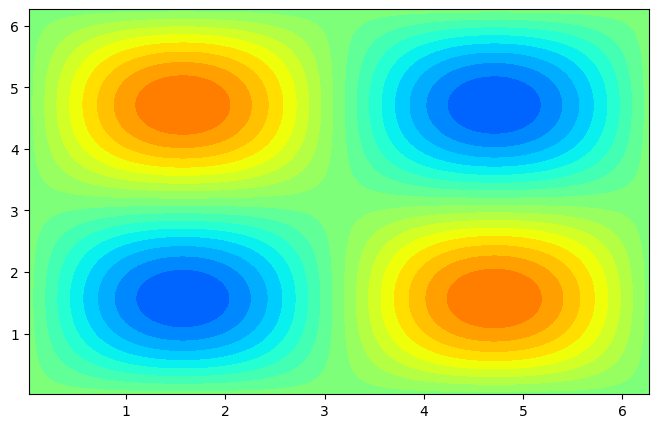

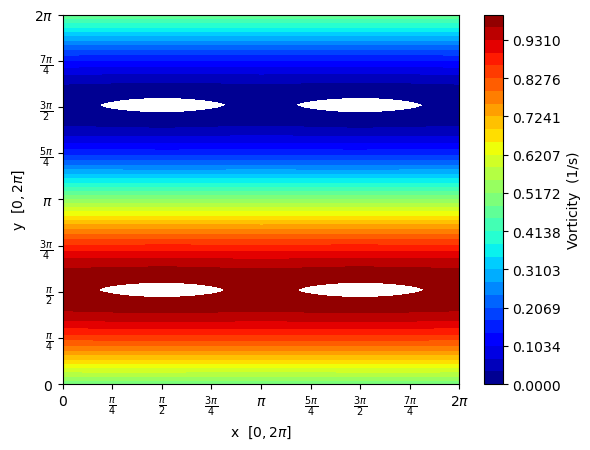

1.0041660656969587
1.0041656890746324
1.004248439112249
1.0042480599180055
1.004330908994266
1.0043305272366088
1.0044134725396623
1.0044130882271747
1.0044961270583788
1.0044957401997192
1.0045788698579436
1.0045784804618458
1.0046616982435612
1.004661306318834
1.004744609518201
1.004744215073728
1.0048276009826862
1.0048272040274269
1.0049106699357842
1.0049102704787711
1.0049938136747603
1.004993411725103
1.0050770294998672
1.0050766250667482
1.0051603146916843
1.0051599077843623
1.005243666541655
1.0052432571694627
1.0053270823396148
1.0053266705119597
1.0054105593738798
1.005410145100244
1.0054940949313373
1.0054936782212778
1.0055776862975359
1.0055772671606837
1.0056613307567739
1.0056609092028348
1.0057450255921896
1.0057446016309446
1.0058287680858535
1.0058283417271574
1.0059125555188542
1.0059121267726374
1.0059963851713924
1.0059959540476597
1.0060802543228682
1.0060798208316986
1.0061641602519726
1.0061637244035202
1.006248100236777
1.0062476620412713
1.0063320715548236
1.

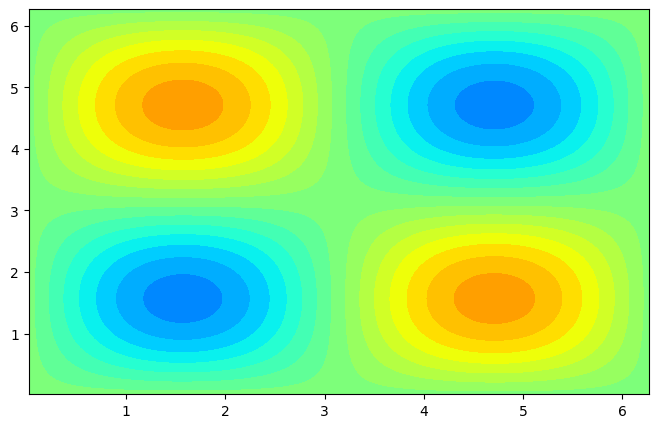

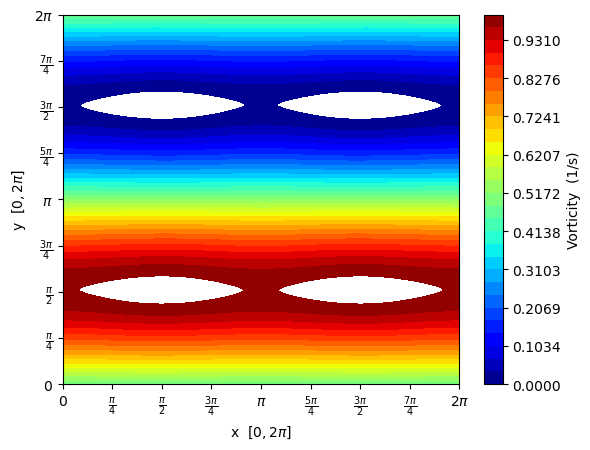

1.0154817462366446
1.0154819776644857
1.0155298341796128
1.0155300650633348
1.015577553756826
1.015577784093772
1.0156249032684415
1.0156251330560524
1.0156718810071383
1.0156721102429496
1.015718485276282
1.0157187139579245
1.0157647143899935
1.0157649425151942
1.015810566673219
1.0158107942398005
1.0158560404617976
1.015856267467677
1.0159011341025288
1.0159013605457192
1.0159458459532413
1.01594607183185
1.0159901743828603
1.0159903996950894
1.0160341177714751
1.016034342515621
1.0160776745104052
1.0160778986848589
1.0161208430022686
1.016121066605515
1.0161636216610475
1.0161638446916654
1.0162060089121552
1.0162062313688167
1.0162480031925019
1.0162482250739724
1.0162896029505604
1.0162898242556984
1.016330806646432
1.0163310273741886
1.0163716127519113
1.0163718329013312
1.0164120197505526
1.0164122393207708
1.0164520261388699
1.0164522451291151
1.0164916304251863
1.016491848834778
1.0165308311218584
1.0165310489502077
1.0165696267602573
1.016569844006867
1.016608015883836
1.0166

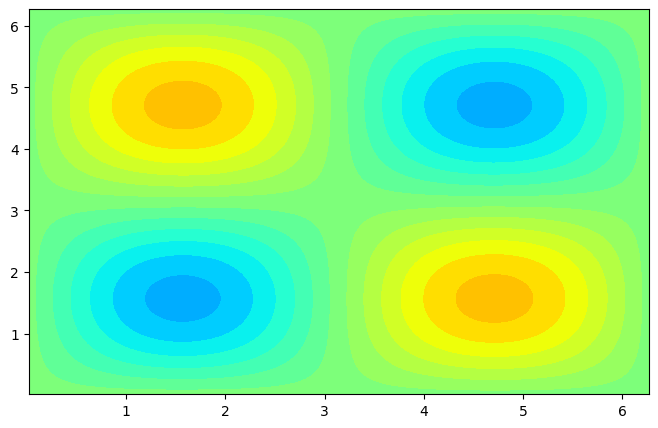

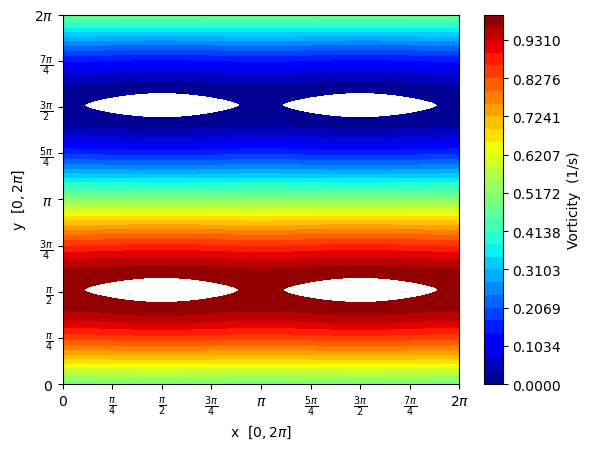

1.01212352393492
1.0121234565518904
1.0120756052254056
1.0120755378368642
1.0120273386933551
1.0120272712865246
1.011978725829994
1.0119786583921402
1.0119297681443844
1.0119297006628192
1.0118804671567263
1.0118803996188075
1.0118308243983138
1.0118307567914469
1.0117808414062548
1.0117807737178952
1.0117305196656725
1.0117304518833279
1.01167986090043
1.011679793011661
1.011628866687286
1.0116287986797083
1.0115775386138386
1.0115774704751246
1.0115258782784786
1.0115258099963589
1.011473887290342
1.011473818852607
1.0114215672692601
1.0114214986637622
1.0113689198457143
1.0113688510603682
1.0113159466607835
1.0113158776835691
1.0112626493660979
1.0112625801850614
1.0112090296237874
1.0112089602270429
1.011155089106433
1.0111550194821635
1.011100829497015
1.0111007596334753
1.011046252488863
1.0110461823743802
1.010991359785605
1.0109912894085804
1.010936153101116
1.010936082450026
1.0108806341594645
1.0108805632228632
1.0108248046948622
1.010824733461382
1.0107686664516102
1.0107685

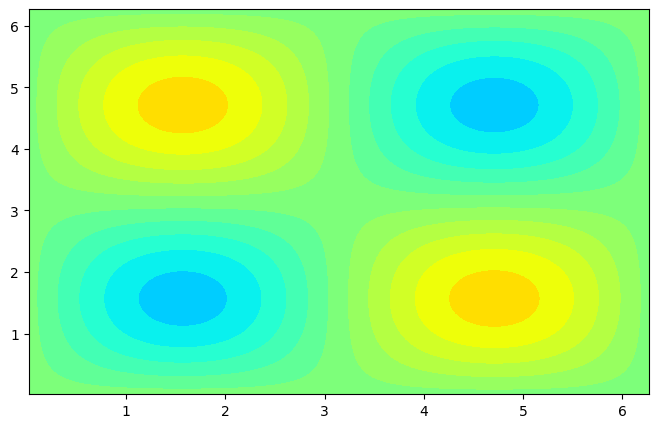

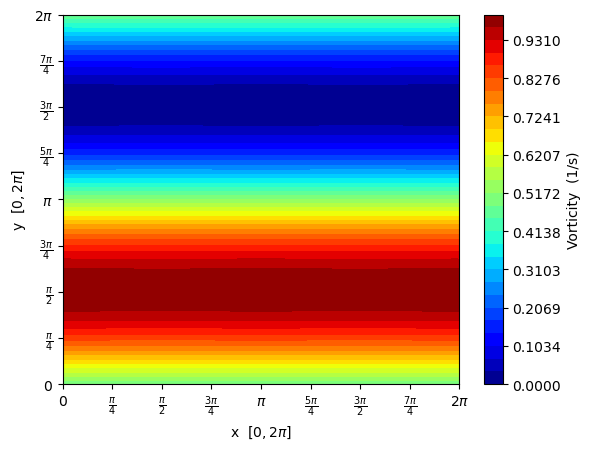

0.9975520646829606
0.9975755678298277
0.9975489605239972
0.9975725311379381
0.9975458535969215
0.9975694924339196
0.9975427442100627
0.9975664520252413
0.9975396326739397
0.9975634102215005
0.9975365193000539
0.9975603673332443
0.9975334044008508
0.997557323671933
0.9975302882896809
0.9975542795498986
0.9975271712807615
0.9975512352803081
0.997524053689136
0.997548191177122
0.9975209358306354
0.9975451475550562
0.9975178180218379
0.9975421047295422
0.9975147005800307
0.9975390630166855
0.9975118855737037
0.9975360227332293
0.9975096041814181
0.9975329841965099
0.9975073223803714
0.9975299477244202
0.997505040410833
0.9975269136353674
0.9975027585138105
0.9975238822482323
0.9975004769310171
0.9975208538823294
0.9974987315916676
0.9975178288573665
0.9974970563292217
0.9975148074934023
0.9974953801758556
0.9975117901108065
0.9974937033270914
0.9975087770302186
0.997492025979149
0.997505768572506
0.9974903483289179
0.9975027650587237
0.9974886705739283
0.9974997668100721
0.9974869929123218

KeyboardInterrupt: 

In [122]:
# Main code
    
V,P,T,rho_total,Y_2 = initial_condition_TGV(Y_2,delta,V,v_0,p_0,rho_0,T_0,C_v,Nx,Ny,x,y,ngc)
#print(rho_total)
# Fill ghost cells on intial conditions
V[:,:,0] = fill_gc_2D(V[:,:,0],ngc)         # Density
V[:,:,1] = fill_gc_2D(V[:,:,1],ngc)         # x-direction Velocity
V[:,:,2] = fill_gc_2D(V[:,:,2],ngc)         # y-direction Velocity
V[:,:,3] = fill_gc_2D(V[:,:,3],ngc)         # Energy
V[:,:,4] = fill_gc_2D(V[:,:,4],ngc)         # Energy
P        = fill_gc_2D(P[:,:],ngc)           # Pressure
T        = fill_gc_2D(T[:,:],ngc)           # Temperature
rho_tot  = fill_gc_2D(rho_tot[:,:],ngc)     # Total Density
Y_2      = fill_gc_2D(Y_2[:,:],ngc)            # Y
#print(V[:,:,0])
Q        = get_Q_from_V(V,Q)

# Create initial time step

dt   = time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T)

# Take derivatives


# Initalization

#import time
current_time                = 0.0
iter                        = 0
flag                        = False

# Plot Times

plot_times                  = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1] # 0.01 is the first plot time  
next_plot_time              = plot_times.pop(0)
t                           = []
ke                          = []
enstrophy                   = []  
ke2                         = []
while(current_time < t_end):    
    if((current_time+dt) > next_plot_time):                 # Statement to make sure that the plot time is the same as the current time
        dt                  = next_plot_time - current_time
        flag                = True                               
    # Time counter
    t.append(current_time)   
   
    #Top one worked
    e    = (V[:,:,4] / (V[:,:,0] + V[:,:,1])   - 0.5 * (V[:,:,2] * V[:,:,2] + V[:,:,3] * V[:,:,3])) 
    #e    = P / ((gamma-1)*(V[:,:,0]+V[:,:,1]))
    #print(e)
    T    = calculate_T_from_e(e, C_v)
    P    = pressure_from_ideal_gas_law(V,R_s,T[:,:],ngc)
    #print(e)
    #print(T)
    #print(P)
    # Enstrophy
    #enstrophy.append(np.mean((df_dy_second_order_centered_2D(V[:,:,1],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,2],dx,ngc)[ngc:-ngc,ngc:-ngc]) * (df_dy_second_order_centered_2D(V[:,:,1],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,2],dx,ngc)[ngc:-ngc,ngc:-ngc])))
    # Calculate P and T
    # Kinetic Energy using E
    # Both Match

    #kinetic  = (np.mean(V[ngc:-ngc,ngc:-ngc,3] - V[ngc:-ngc,ngc:-ngc,0] * e[ngc:-ngc,ngc:-ngc] ))
    # kinetic  = (np.mean(V[ngc:-ngc,ngc:-ngc,3] - V[ngc:-ngc,ngc:-ngc,0] * C_v*T[ngc:-ngc,ngc:-ngc] ))
    # ke.append(kinetic)

    # # Kinetic Energy using Velocity
    # kinetic2  = (np.mean(V[ngc:-ngc,ngc:-ngc,0]* 0.5 * (V[ngc:-ngc,ngc:-ngc,1] * V[ngc:-ngc,ngc:-ngc,1] + V[ngc:-ngc,ngc:-ngc,2] * V[ngc:-ngc,ngc:-ngc,2])))
    # ke2.append(kinetic2)

    # Calculate Tau's
    tau_xx, tau_yy, tau_xy = calculate_tau(V[:,:,2],V[:,:,3],dx,dy,mu)

    J = get_J(J, V, D)
    
    # Q[0]    =   (- df_dx(rho*u) - df_dy(rho*v) + D * df_dx(rho*Y[0]) + D * df_dy(rho*Y[0]))*dt
    # Q[:,:,0] += -((df_dx_second_order_centered_2D(Q[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,3],dy,ngc))
    #               + D * (df_dx_second_order_centered_2D(df_dx_second_order_centered_2D(Q[:,:,0],dx,ngc),dx,ngc) 
    #               + df_dx_second_order_centered_2D(df_dy_second_order_centered_2D(Q[:,:,0],dy,ngc),dy,ngc)))* dt

    # Q[:,:,0] += -((df_dx_second_order_centered_2D(Q[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,3],dy,ngc)) 
    #               + (Q[:,:,0] + Q[:,:,1]) * D * (non_conservative_d2f_dx2_second_order_centered_2D(Y_2[:,:,0], dx, ngc) + non_conservative_d2f_dy2_second_order_centered_2D(Y_2[:,:,0], dy, ngc)))*dt
    # k1 = Q[:,:,0]
    # k2 = Q[:,:,0] + dt/2 * (-df_dx_second_order_centered_2D(Q[:,:,2],dx,ngc) - df_dy_second_order_centered_2D(Q[:,:,3],dy,ngc) + J[:,:,0])
    # k3 = Q[:,:,0] + dt/2 * k2
    # k4 = Q[:,:,0] + dt * k3
    # Q[:,:,0] +=  dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    Q[:,:,0] += -((df_dx_second_order_centered_2D(Q[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,3],dy,ngc)) - D * (non_conservative_d2f_dx2_second_order_centered_2D(V[:,:,0], dx, ngc) + non_conservative_d2f_dy2_second_order_centered_2D(V[:,:,0], dy, ngc)))*dt
    

    
    # Q[1]    =   (- df_dx(rho*u) - df_dy(rho*v) + D * df_dx(rho*Y[1]) + D * df_dy(rho*Y[1]))*dt
    # Q[:,:,1] += -((df_dx_second_order_centered_2D(Q[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,3],dy,ngc))
    #               + D * (df_dx_second_order_centered_2D(df_dx_second_order_centered_2D(Q[:,:,1],dx,ngc),dx,ngc) 
    #               + df_dx_second_order_centered_2D(df_dy_second_order_centered_2D(Q[:,:,1],dy,ngc),dy,ngc)))* dt
    # Q[:,:,1] += -((df_dx_second_order_centered_2D(Q[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,3],dy,ngc))
    #               + (Q[:,:,0] + Q[:,:,1]) * D * (non_conservative_d2f_dx2_second_order_centered_2D(Y_2[:,:,1], dx, ngc) + non_conservative_d2f_dy2_second_order_centered_2D(Y_2[:,:,1], dy, ngc))) *dt
    Q[:,:,1] += -((df_dx_second_order_centered_2D(Q[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,3],dy,ngc)) - D * (non_conservative_d2f_dx2_second_order_centered_2D(V[:,:,1], dx, ngc) + non_conservative_d2f_dy2_second_order_centered_2D(V[:,:,1], dy, ngc)))*dt
    # 
    Q[:,:,2] += (-(df_dx_second_order_centered_2D(Q[:,:,2] * V[:,:,2] + P[:,:],dx,ngc) 
                   + df_dy_second_order_centered_2D(Q[:,:,2] * V[:,:,3],dy,ngc)) + 
                   df_dx_second_order_centered_2D(tau_xx,dx,ngc) + df_dy_second_order_centered_2D(tau_xy,dy,ngc))*dt
    
    Q[:,:,3] += (-(df_dx_second_order_centered_2D( Q[:,:,2]* V[:,:,3],dx,ngc) # I am worried about using q[2] since we just updated it V[:,:,2]*(V[:,:,1]+V[:,:,0])
                   + df_dy_second_order_centered_2D(Q[:,:,3] * V[:,:,3] + P[:,:],dy,ngc)) 
                   + df_dx_second_order_centered_2D(tau_xy,dx,ngc) + df_dy_second_order_centered_2D(tau_yy,dy,ngc))*dt
    #print(Q[:,:,3])
    Q[:,:,4] += (-df_dx_second_order_centered_2D((Q[:,:,4] + P[:,:]) * V[:,:,2],dx,ngc) - df_dy_second_order_centered_2D((Q[:,:,4] + P[:,:]) * V[:,:,3],dy,ngc)
    + df_dx_second_order_centered_2D(tau_xx * V[:,:,2] + tau_xy * V[:,:,3] + kappa * df_dx_second_order_centered_2D(T[:,:],dx,ngc),dx,ngc) 
    + df_dy_second_order_centered_2D(tau_xy * V[:,:,2] + tau_yy * V[:,:,3] + kappa * df_dy_second_order_centered_2D(T[:,:],dy,ngc),dy,ngc))*dt
    # + df_dx_second_order_centered_2D(C_p * T[:,:] * (J[:,:,0] + J[:,:,1]) ,dx,ngc)
    # + df_dy_second_order_centered_2D(C_p * T[:,:] * (J[:,:,0] + J[:,:,1]) ,dy,ngc))* dt
    # + df_dx_second_order_centered_2D(C_p * T[:,:] * D * (df_dx_second_order_centered_2D(V[:,:,0],dx,ngc) + df_dx_second_order_centered_2D(V[:,:,1],dx,ngc)) ,dx,ngc)
    # + df_dy_second_order_centered_2D(C_p * T[:,:] * D *(df_dy_second_order_centered_2D(V[:,:,0] ,dx,ngc) + df_dy_second_order_centered_2D(V[:,:,1] ,dx,ngc)) ,dy,ngc))* dt

    #print(Q[:,:,4])
    # Wrote two energy equations to validate my code
    # Q[:,:,3] += (-(df_dx_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,1],dx,ngc) + df_dy_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,2],dy,ngc)) 
    #              + non_conservative_d2f_dx2_second_order_centered_2D(tau_xx*V[:,:,1]+tau_xy*V[:,:,2],dx,ngc) + non_conservative_d2f_dy2_second_order_centered_2D(tau_xy*V[:,:,1]+tau_yy*V[:,:,2],dx,ngc) 
    #              + kappa * (non_conservative_d2f_dx2_second_order_centered_2D(T[:,:],dx,ngc) + non_conservative_d2f_dy2_second_order_centered_2D(T[:,:],dy,ngc)))*dt
#print(Q[:,:,4])

    print(np.max(Q[:,:,0]/( V[:,:,0] + V[:,:,1])))
    print(np.max(Q[:,:,1]/( V[:,:,0] + V[:,:,1])))

    # Fill ghost cells for Q
    Q[:,:,0] = fill_gc_2D(Q[:,:,0],ngc)
    Q[:,:,1] = fill_gc_2D(Q[:,:,1],ngc)
    Q[:,:,2] = fill_gc_2D(Q[:,:,2],ngc)
    Q[:,:,3] = fill_gc_2D(Q[:,:,3],ngc)
    Q[:,:,4] = fill_gc_2D(Q[:,:,4],ngc)

    V        = get_V_from_Q(Q,V)
    
    current_time            += dt
    dt                      = time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T) 
    
    
    iter        += 1
    
    if (flag == True):          #Statement to plot when the current _time == next_plot_time
        X,Y = np.meshgrid(x,y)
        print(current_time)
        pyplot.figure(figsize=(8,5))
        vorticity           = df_dy_second_order_centered_2D(V[:,:,2],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,3],dx,ngc)[ngc:-ngc,ngc:-ngc]
        contour             = pyplot.contourf(X[ngc:-ngc,ngc:-ngc], Y[ngc:-ngc,ngc:-ngc],  vorticity, cmap = "jet",levels=np.linspace(-200,200,30)) # Used Chatgpt for levels
        pyplot.show()
        contour             = pyplot.contourf(X[ngc:-ngc,ngc:-ngc], Y[ngc:-ngc,ngc:-ngc],  Q[ngc:-ngc,ngc:-ngc,0]/(Q[ngc:-ngc,ngc:-ngc,1] + Q[ngc:-ngc,ngc:-ngc,0]), cmap = "jet",levels=np.linspace(0,1,30)) # Used Chatgpt for levels
        cbar                = pyplot.colorbar(contour) # Used Chatgpt for colorbar
        #cbar.set_ticks(np.linspace(-200,200,9))  # Used Chatgpt for colorbar ticks
        cbar.set_label("Vorticity  (1/s)")        # Used Chatgpt for colorbar label
        pyplot.xlim(0,2*np.pi)
        pyplot.xticks(np.linspace(0,2*np.pi,9),[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
                  r"$\frac{5\pi}{4}$", r"$\frac{3\pi}{2}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]) 
        pyplot.ylim(0,2*np.pi)
        pyplot.yticks(np.linspace(0,2*np.pi,9),[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
                  r"$\frac{5\pi}{4}$", r"$\frac{3\pi}{2}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]) 
        pyplot.xlabel(r"x  [$0, 2\pi$]")
        pyplot.ylabel(r"y  [$0, 2\pi$]")
        pyplot.show()
        if plot_times:  #Statement to change next_plot_time and reset flag 
            next_plot_time  = plot_times.pop(0)                                
            flag            = False
        if next_plot_time == 0.02 and flag == True:
            pyplot.figure(figsize=(8,5))
            pyplot.plot(t, ke) # Used Chatgpt for levels
            pyplot.xlabel("Time (s)")
            pyplot.ylabel("Average Kinetic Energy (kg/(m*s$^2$))")
            pyplot.show()
            pyplot.figure(figsize=(8,5))
            pyplot.plot(t, ke2) # Used Chatgpt for levels
            pyplot.xlabel("Time (s)")
            pyplot.ylabel("Average Kinetic Energy (kg/(m*s$^2$))")
            pyplot.show()
            pyplot.figure(figsize=(8,5))
            pyplot.plot(t, enstrophy) # Used Chatgpt for levels
            pyplot.xlabel("Time (s)")
            pyplot.ylabel("Average Enstrophy (m$^2$/s$^2$)")
            pyplot.show()
            break
    


In [ ]:
# # Main code

# # Old Code
    
# V, P, T = initial_condition_TGV(V,v_0,p_0,rho_0,T_0,C_v,Nx,Ny,x,y,ngc)

# # Fill ghost cells on intial conditions
# V[:,:,0] = fill_gc_2D(V[:,:,0],ngc)         # Density
# V[:,:,1] = fill_gc_2D(V[:,:,1],ngc)         # x-direction Velocity
# V[:,:,2] = fill_gc_2D(V[:,:,2],ngc)         # y-direction Velocity
# V[:,:,3] = fill_gc_2D(V[:,:,3],ngc)         # Energy
# P        = fill_gc_2D(P[:,:],ngc)           # Pressure
# T        = fill_gc_2D(T[:,:],ngc)           # Temperature

# Q        = get_Q_from_V(V,Q)

# # Create initial time step

# dt   = time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T)

# # Take derivatives


# # Initalization

# #import time
# current_time                = 0.0
# iter                        = 0
# flag                        = False

# # Plot Times

# plot_times                  = [0.02]         
# next_plot_time              = plot_times.pop(0)  
# t                           = []
# ke                          = []
# enstrophy                   = []
# while(current_time < t_end):    
#     if((current_time+dt) > next_plot_time):                 # Statement to make sure that the plot time is the same as the current time
#         dt                  = next_plot_time - current_time
#         flag                = True                               
#     t.append(current_time)
#     # Kinetic energy
#     kinetic  = (np.mean(V[:,:,0]* 0.5 * (V[:,:,1] * V[:,:,1] + V[:,:,2] * V[:,:,2])))
#     ke.append(kinetic)
    
#     # Enstrophy
#     enstrophy.append(np.mean((df_dy_second_order_centered_2D(V[:,:,1],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,2],dx,ngc)[ngc:-ngc,ngc:-ngc]) * (df_dy_second_order_centered_2D(V[:,:,1],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,2],dx,ngc)[ngc:-ngc,ngc:-ngc])))
  
#     # Calculate P and T
#     e    = P / ((gamma-1)*V[:,:,0]) 
#     T    = calculate_T_from_e(e, C_v)
#     P    = pressure_from_ideal_gas_law(V[:,:,0],R_s,T[:,:],ngc)

#     # Calculate Tau's
#     tau_xx, tau_yy, tau_xy = calculate_tau(V[:,:,1],V[:,:,2],dx,dy,mu)
    

#     Q[:,:,0] += -(df_dx_second_order_centered_2D(Q[:,:,1],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,2],dy,ngc))* dt
    
#     Q[:,:,1] += (-(df_dx_second_order_centered_2D(Q[:,:,1]*V[:,:,1],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,1]*V[:,:,2],dy,ngc)+df_dx_second_order_centered_2D(P[:,:],dx,ngc))+df_dx_second_order_centered_2D(tau_xx,dx,ngc) + df_dy_second_order_centered_2D(tau_xy,dy,ngc))*dt
    
#     Q[:,:,2] += (-(df_dx_second_order_centered_2D(Q[:,:,1]*V[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,2]*V[:,:,2],dy,ngc)+df_dx_second_order_centered_2D(P[:,:],dx,ngc))+df_dx_second_order_centered_2D(tau_xy,dx,ngc) + df_dy_second_order_centered_2D(tau_yy,dy,ngc))*dt

#     Q[:,:,3] += (-(df_dx_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,1],dx,ngc) + df_dy_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,2],dy,ngc)) 
#                  + df_dx_second_order_centered_2D(tau_xx*V[:,:,1]+tau_xy*V[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(tau_xy*V[:,:,1]+tau_yy*V[:,:,2],dx,ngc) 
#                  + kappa * (non_conservative_d2f_dx2_second_order_centered_2D(T[:,:],dx,ngc) + non_conservative_d2f_dy2_second_order_centered_2D(T[:,:],dy,ngc)))*dt

#     Q[:,:,0] = fill_gc_2D(Q[:,:,0],ngc)
#     Q[:,:,1] = fill_gc_2D(Q[:,:,1],ngc)
#     Q[:,:,2] = fill_gc_2D(Q[:,:,2],ngc)
#     Q[:,:,3] = fill_gc_2D(Q[:,:,3],ngc)

#     V        = get_V_from_Q(Q,V)
#     current_time            += dt
#     dt                      = time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T) 
    
#     #print(current_time)
#     iter        += 1
    
#     if (flag == True):          #Statement to plot when the current _time == next_plot_time
#         pyplot.figure(figsize=(8,5))
#         pyplot.plot(t, ke) # Used Chatgpt for levels
#         pyplot.xlabel("Time (s)")
#         pyplot.ylabel("Kinetic Energy (kg/(m*s$^2$))")
#         pyplot.show()
#         pyplot.figure(figsize=(8,5))
#         pyplot.plot(t, enstrophy) # Used Chatgpt for levels
#         pyplot.xlabel("Time (s)")
#         pyplot.ylabel("Average Enstrophy (m$^2$/s$^2$)")
#         pyplot.show()
#         if plot_times:  #Statement to change next_plot_time and reset flag 
#             next_plot_time  = plot_times.pop(0)                                
#             flag            = False
#         if next_plot_time == 0.02 and flag == True:
#             pyplot.figure(figsize=(8,5))
#             pyplot.plot(t, ke) # Used Chatgpt for levels
#             pyplot.xlabel("Time (s)")
#             pyplot.ylabel("Kinetic Energy (kg/(m*s$^2$))")
#             pyplot.show()
#             pyplot.figure(figsize=(8,5))
#             pyplot.plot(t, enstrophy) # Used Chatgpt for levels
#             pyplot.xlabel("Time (s)")
#             pyplot.ylabel("Average Enstrophy (m$^2$/s$^2$)")
#             pyplot.show()
#             break
    
